In [1]:
#basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

#metrics en cv
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, KFold

#regression models
from sklearn.linear_model import LinearRegression

SEED = 1337
test_df = pd.read_csv('test.csv', parse_dates=['date_hour'])
train_df = pd.read_csv('train.csv', parse_dates=['date_hour'])

In [2]:
#functies
def highlight_min(s, props=''):
    """Dit functie highlight het laagste waarde van elk kolom.
    Maak gebruik van DataFrame.style.apply().
    
    Parameters:
    -----------
    s: DataFrame, the dataframe to highlight on.
    
    props: str, the color and background color.
    
    Returns:
    np.where(s == np.nanmin(s.values), props, ''): the DataFrame with highlights.
    --------
    
    """
    return np.where(s == np.nanmin(s.values), props, '')

In [3]:
#classes
class date_time_resample:
    def __init__(self, data):
        self.dfh = data.set_index('date_hour')
        self.dfh.resample('H').agg({'holiday': np.mean, 'weathersit': np.mean,
                                    'temp': np.mean, 'hum': np.mean, 'windspeed': np.mean})
        self.dfh = self.dfh.reset_index()
        self.dfh['hour'] = self.dfh['date_hour'].dt.hour
        self.dfh['DayName'] = self.dfh['date_hour'].dt.day_name()
        self.dfh.set_index('date_hour', inplace=True)
        

In [4]:
dfh_test = date_time_resample(data=test_df)
dfh_train = date_time_resample(data=train_df)
display(dfh_test.dfh)
display(dfh_train.dfh)

,holiday,weathersit,temp,atemp,hum,windspeed,hour,DayName
date_hour,,,,,,,,
2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,0,Saturday
2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,1,Saturday
2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,2,Saturday
2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,3,Saturday
2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,4,Saturday
...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,0,1,0.38,0.3939,0.50,0.3881,19,Wednesday
2012-12-19 20:00:00,0,1,0.36,0.3485,0.57,0.2239,20,Wednesday
2012-12-19 21:00:00,0,1,0.34,0.3182,0.61,0.2239,21,Wednesday


,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour,DayName
date_hour,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,0,Saturday
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,Saturday
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2,Saturday
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,3,Saturday
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,4,Saturday
...,...,...,...,...,...,...,...,...,...
2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,19,Friday
2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,20,Friday
2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,21,Friday


## EDA

In [5]:
display(dfh_test.dfh.info())
display(dfh_train.dfh.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 456 entries, 2012-12-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     456 non-null    int64  
 1   weathersit  456 non-null    int64  
 2   temp        456 non-null    float64
 3   atemp       456 non-null    float64
 4   hum         456 non-null    float64
 5   windspeed   456 non-null    float64
 6   hour        456 non-null    int64  
 7   DayName     456 non-null    object 
dtypes: float64(4), int64(3), object(1)
memory usage: 32.1+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16637 entries, 2011-01-01 00:00:00 to 2012-11-30 23:00:00
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     16637 non-null  int64  
 1   weathersit  16637 non-null  int64  
 2   temp        16637 non-null  float64
 3   atemp       16637 non-null  float64
 4   hum         16637 non-null  float64
 5   windspeed   16637 non-null  float64
 6   cnt         16637 non-null  int64  
 7   hour        16637 non-null  int64  
 8   DayName     16637 non-null  object 
dtypes: float64(4), int64(4), object(1)
memory usage: 1.3+ MB


None

#### alle features zijn numeriek behalve de day name

In [6]:
display(dfh_test.dfh.describe().style.apply(highlight_min, props='color:Black;background-color:Grey', axis=0))
display(dfh_train.dfh.describe().style.apply(highlight_min, props='color:Black;background-color:Grey', axis=0))

,holiday,weathersit,temp,atemp,hum,windspeed,hour
count,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000
mean,0.000000,1.592105,0.360132,0.363691,0.714868,0.157639,11.500000
std,0.000000,0.607882,0.079432,0.076354,0.177732,0.106499,6.929789
min,0.000000,1.000000,0.160000,0.181800,0.330000,0.000000,0.000000
25%,0.000000,1.000000,0.300000,0.303000,0.560000,0.089600,5.750000
50%,0.000000,2.000000,0.360000,0.363600,0.750000,0.134300,11.500000
75%,0.000000,2.000000,0.400000,0.409100,0.870000,0.223900,17.250000
max,0.000000,3.000000,0.600000,0.621200,1.000000,0.492500,23.000000


,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009,11.547875
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755,6.914199
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000,6.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000,12.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000,18.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000,23.000000


In [7]:
print(dfh_train.dfh.isna().sum())
print(dfh_test.dfh.isna().sum())

holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
hour          0
DayName       0
dtype: int64
holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
hour          0
DayName       0
dtype: int64


holiday      -0.026586
weathersit   -0.140111
temp          0.409245
atemp         0.404820
hum          -0.327288
windspeed     0.097006
cnt           1.000000
hour          0.396945
Name: cnt, dtype: float64


C:\Users\akers\AppData\Local\Temp\ipykernel_31900\1940348218.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(dfh_train.dfh.corr()['cnt'])


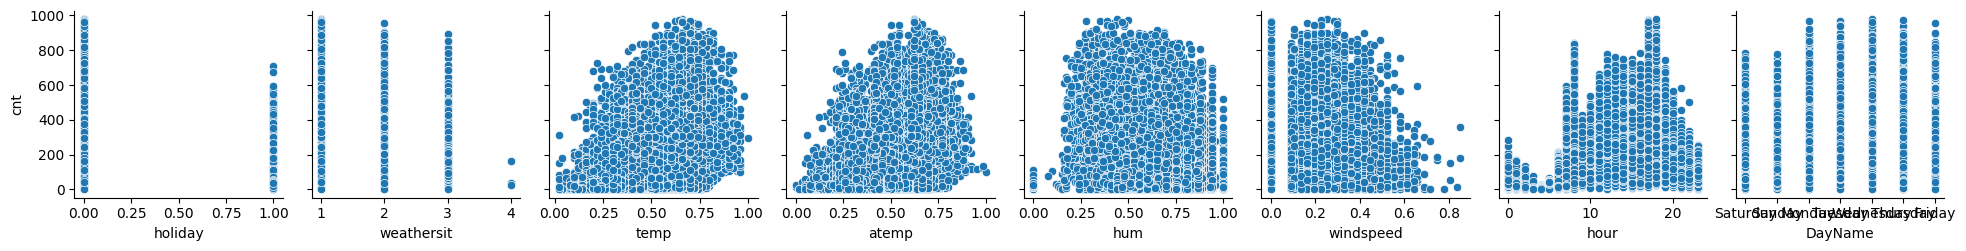

In [8]:
x_cols = dfh_train.dfh.columns.drop('cnt')
print(dfh_train.dfh.corr()['cnt'])
fig = sns.pairplot(
    dfh_train.dfh,
    x_vars=x_cols,
    y_vars='cnt'
)
plt.show()